<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Trend-following-benchmark-summary" data-toc-modified-id="Trend-following-benchmark-summary-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Trend-following benchmark summary</a></span></li><li><span><a href="#Time-series-momentum-performance" data-toc-modified-id="Time-series-momentum-performance-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Time-series momentum performance</a></span><ul class="toc-item"><li><span><a href="#Run-backtest" data-toc-modified-id="Run-backtest-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Run backtest</a></span></li><li><span><a href="#Trend-following-portfolio" data-toc-modified-id="Trend-following-portfolio-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Trend-following portfolio</a></span></li><li><span><a href="#Performance-breakdown-by-futures-contract" data-toc-modified-id="Performance-breakdown-by-futures-contract-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Performance breakdown by futures contract</a></span></li></ul></li><li><span><a href="#Reference" data-toc-modified-id="Reference-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Reference</a></span></li></ul></div>

# Trend-following benchmark summary

This notebook displays the performance of trend-following strategies across major asset classes. The trend signal used here is the same as the one proposed in Moskowitz et al (2012) to illustrate the basic properties of trend-following strategies. Concretely, the signal at time $t$ is defined in the paper as follows:
$$
signal_t^s = {\rm sign} \left( r_{t-12, t}^{s} \right) \frac{40\%}{\sigma_{t}^{s}}  
$$
where $r_{t-12, t}^{s}$ is a return from time $t-12$ to $t$ for an instrument $s$ (return is measured on a monthly basis), $\sigma_{t}^{s}$ is a trailing realised volatility. Therefore the trend signal is just binary based on the past 1 year returns, adjusted by the realised volatility to achieve the target volatility (40%).

Please note that like the notebook for long-only returns, results are computed by using a private library called `vivace`.

In [1]:
%matplotlib inline
from functools import partial
import logging
import re 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('bmh')

from vivace.backtest import signal
from vivace.backtest import post_process
from vivace.backtest.engine import EngineFactory, all_futures
from vivace.backtest.enums import Strategy
from vivace.backtest.stats import Performance, PerfStats

# Time-series momentum performance

In [2]:
name_map = all_futures.set_index('ticker')['name']
instruments = name_map.index.tolist()

There are 117 futures contract to consider. The trading universe covers a wide range of asset classes and regions, and is made up of following instruments:
- Equity index futures (both DM and EM)
- Government bond futures
- Short-term interest rate futures
- FX futures (both DM and EM)
- Commodity futures (energy, grains, softs, agri, metals)
- Volatility index futures

where the same trend detection method is applied.

In [3]:
name_map

ticker
FATX                     ATX Futures
AD         Australian Dollar Futures
AC          MSCI World Index Futures
AE               Amsterdam AEX Index
AP                     SPI 200 Index
                    ...             
FF      30 Day Federal Funds Futures
RR                        Rough Rice
S                    Soybean Futures
TU             2-Year T-Note Futures
W                      Wheat Futures
Name: name, Length: 117, dtype: object

## Run backtest
We can initiate an engine instance by specifying certain signal methodologies. Here in addition to using the proposed trend signal formula, the signal is then observed on a weekly basis to avoid exessive trading (defined in the `post_process` argument).

In [4]:
engine = EngineFactory.create(
    strategy=Strategy.FUTURES_UNIVARIATE.value,
    instrument=instruments,
    nth_expiry=1,
    vol_scale_method=partial(signal.volatility_scale, shift=0, target_volatility=0.4),
    signal_method=partial(signal.tsmom_moskowitz_2012, 
                          post_process=partial(post_process.asfreq, freq='w', method='pad')),
    log_level=logging.WARN,
)
engine.run()

## Trend-following portfolio

The portfolio is constructed with a equal-risk (realised volatility) weighting methodology. This is simple to compute however in practice this is not desiable because of various reasons. The biggest reason is liquidity because not all of the futures have the same liquidity. Certainly S&P500 futures would have much deeper liquidity than some isoteric commodity futures.

In [5]:
portfolio_return = (engine.get_return(col_name_suffix='strategy', is_gross=True)
                    .div(len(instruments))
                    .cumsum()
                    .rename('Trend-following portfolio'))

This portfolio worked well over 60 years with a Sharpe ratio of above 1.0 (gross of costs), however notice that the performance seems stalling for the last 5 years or so.

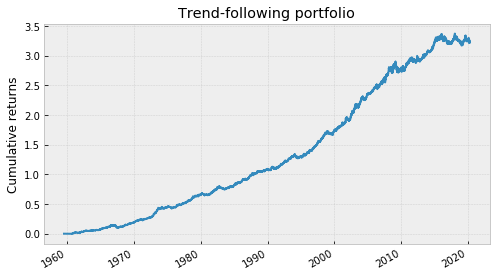

In [6]:
fig, ax = plt.subplots(figsize=(8, 4.5))
portfolio_return.plot(ax=ax);
ax.set_title('Trend-following portfolio')
ax.set_ylabel('Cumulative returns');

In [7]:
portfolio_return.pipe(Performance, return_type='diff').summary()

,Trend-following portfolio
annualised return,0.051998
annualised vol,0.051602
Sharpe ratio,1.007666
max drawdown,0.200516
Calmar ratio,0.259322
skewness,-0.087072
kurtosis,16.077104


## Performance breakdown by futures contract

Most of the contracts contributed positively when the trend-following signal is applied.

In [8]:
instrument_returns = engine.get_return_by_instrument(col_name_suffix='strategy', is_gross=True).cumsum()

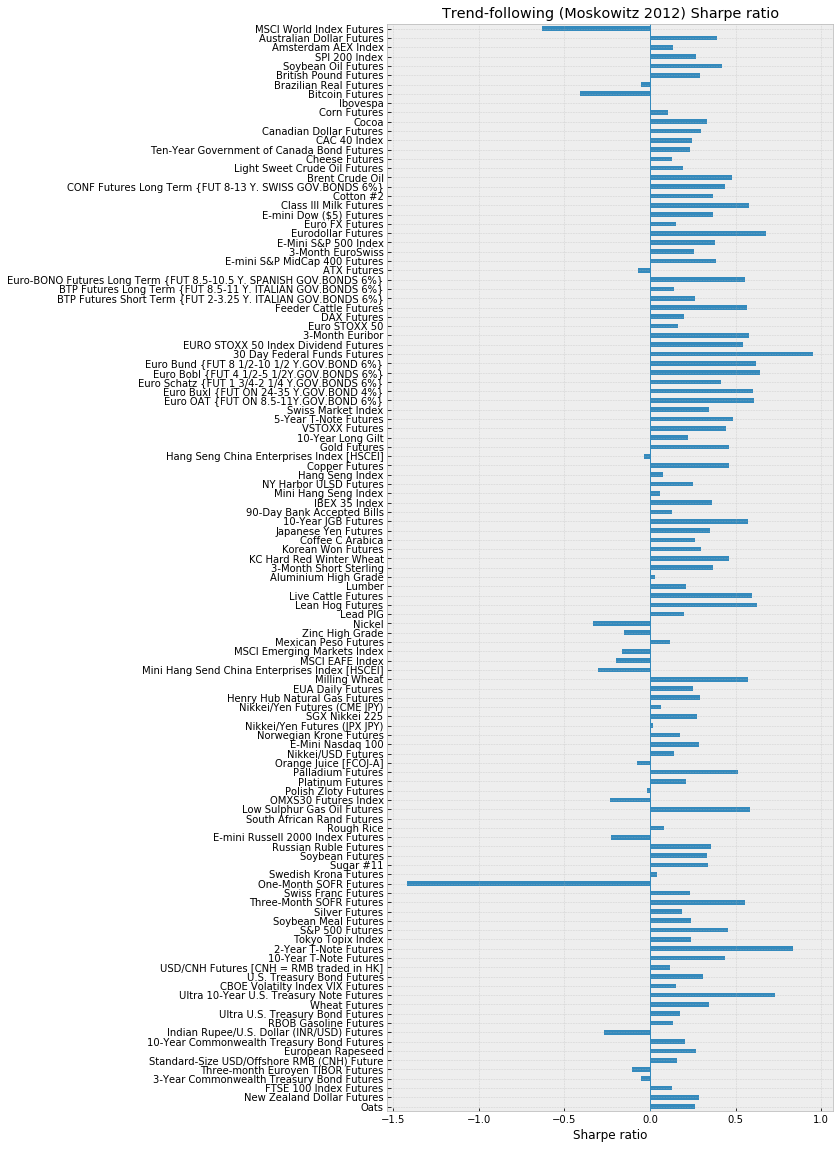

In [9]:
fig, ax = plt.subplots(figsize=(8, 20))
(instrument_returns.pipe(Performance, return_type='diff').summary()
 .loc[PerfStats.SHARPE.value, :]
 .loc[::-1]
 .rename(index=name_map)
 .plot(kind='barh', ax=ax));

ax.set_title('Trend-following (Moskowitz 2012) Sharpe ratio')
ax.set_xlabel(PerfStats.SHARPE.value);
ax.axvline(0, lw=1);

# Reference
Moskowitz, T.J., Ooi, Y.H. and Pedersen, L.H., 2012. Time series momentum. Journal of financial economics, 104(2), pp.228-250.